## NER命名实体识别

### hugging face 的中文数据集
- qgyd2021/chinese_ner_sft
  - 有很多子集，数据格式如下
  - 纯美韩国女主播性感热舞变形金刚
  - { "start_idx": [ 2, 11 ], "end_idx": [ 4, 15 ], "entity_text": [ "韩国", "变形金刚" ], "entity_label": [ "MISC", "TELEVISION" ], "entity_names": [ [ "其它实体" ], [ "电视", "电视节目", "影视作品", "影视节目" ] ] }
- peoples_daily_ner
  - 这个是我理解的那种数据格式
  - [ "沙", "特", "队", "教", "练", "佩", "雷", "拉", "：", "两", "支", "队", "都", "想", "胜", "，", "因", "此", "都", "作", "出", "了", "最", "大", "的", "努", "力", "。" ]
  - [ 3, 4, 4, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]

- 参考资料
  - http://m.tnblog.net/hb/article/details/8266
  - https://www.cnblogs.com/shengshengwang/p/17674861.html

In [57]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from tqdm import tqdm
from pprint import pprint
import numpy as np

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
dataset = load_dataset("peoples_daily_ner")

In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [61]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 20865
})

In [62]:
# 初始化BERT tokenizer和模型
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

##### 测试tokenizer

In [8]:
# 编码测试
out = tokenizer.batch_encode_plus(
    [[
        '海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间',
        '的', '海', '域', '。'
    ],
     [
         '这', '座', '依', '山', '傍', '水', '的', '博', '物', '馆', '由', '国', '内', '一',
         '流', '的', '设', '计', '师', '主', '持', '设', '计', '。'
     ]],
    truncation=True,
    padding=True,
    return_tensors='pt',
    max_length=20,
    is_split_into_words=True)
#还原编码为句子
print(tokenizer.decode(out['input_ids'][0]))
print(tokenizer.decode(out['input_ids'][1]))
for k, v in out.items():
    print(k, v)

[CLS] 海 钓 比 赛 地 点 在 厦 门 与 金 门 之 间 的 海 域 。 [SEP]
[CLS] 这 座 依 山 傍 水 的 博 物 馆 由 国 内 一 流 的 设 计 [SEP]
input_ids tensor([[ 101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305,  680, 7032,
         7305,  722, 7313, 4638, 3862, 1818,  511,  102],
        [ 101, 6821, 2429,  898, 2255,  988, 3717, 4638, 1300, 4289, 7667, 4507,
         1744, 1079,  671, 3837, 4638, 6392, 6369,  102]])
token_type_ids tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [9]:
dataset["train"].features["ner_tags"].feature

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [10]:
len(dataset["train"].features["ner_tags"].feature.names)

7

In [11]:
id2label = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
label2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}
# label2id = {v:k for k, v in id2label.items()}
# label2id

In [12]:
def collate_fn_orgin(data):
    tokens = [i[0] for i in data]
    labels = [i[1] for i in data]
    #编码
    inputs = tokenizer.batch_encode_plus(tokens,
                                         truncation=True,
                                         padding=True,
                                         return_tensors='pt',
                                         max_length=512,
                                         is_split_into_words=True)
    #求一批数据中最长的句子长度
    lens = inputs['input_ids'].shape[1]
    #在labels的头尾补充7，把所有的labels补充成统一的长度
    for i in range(len(labels)):
        labels[i] = [7] + labels[i]
        labels[i] += [7] * lens
        labels[i] = labels[i][:lens]
    #把编码结果移动到计算设备
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    #把统一长度的labels组装成矩阵，并移动到计算设备
    labels = torch.LongTensor(labels).to(device)
    return inputs, labels

In [13]:
data = [
    ([
        '海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间',
        '的', '海', '域', '。'
    ], [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0]),
    ([
        '这', '座', '依', '山', '傍', '水', '的', '博', '物', '馆', '由', '国', '内', '一',
        '流', '的', '设', '计', '师', '主', '持', '设', '计', '，', '整', '个', '建', '筑',
        '群', '精', '美', '而', '恢', '宏', '。'
    ], [
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    ]),
]
#试算
inputs, labels = collate_fn_orgin(data)
for k, v in inputs.items():
    print(k, v.shape, v)
print('labels', labels.shape, labels)

input_ids torch.Size([2, 37]) tensor([[ 101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305,  680, 7032,
         7305,  722, 7313, 4638, 3862, 1818,  511,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 6821, 2429,  898, 2255,  988, 3717, 4638, 1300, 4289, 7667, 4507,
         1744, 1079,  671, 3837, 4638, 6392, 6369, 2360,  712, 2898, 6392, 6369,
         8024, 3146,  702, 2456, 5029, 5408, 5125, 5401, 5445, 2612, 2131,  511,
          102]], device='cuda:0')
token_type_ids torch.Size([2, 37]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
attention_mask torch.Size([2, 37]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
     

In [88]:
print(dataset['train'][5:8])

{'id': ['5', '6', '7'], 'tokens': [['克', '马', '尔', '的', '女', '儿', '让', '娜', '今', '年', '读', '五', '年', '级', '，', '她', '所', '在', '的', '班', '上', '有', '3', '0', '多', '名', '同', '学', '，', '该', '班', '的', '“', '家', '委', '会', '”', '由', '1', '0', '名', '家', '长', '组', '成', '。'], ['参', '加', '步', '行', '的', '有', '男', '有', '女', '，', '有', '年', '轻', '人', '，', '也', '有', '中', '年', '人', '。'], ['沙', '特', '队', '教', '练', '佩', '雷', '拉', '：', '两', '支', '队', '都', '想', '胜', '，', '因', '此', '都', '作', '出', '了', '最', '大', '的', '努', '力', '。']], 'ner_tags': [[1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 4, 4, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [65]:
def collate_fn(data):
    tokens, labels  = [], []
    for sample in data:
        if not sample['tokens']:
            continue
        tokens.append(sample['tokens'])
        labels.append(sample['ner_tags'])

    # tokens = data['tokens']
    # labels = data['ner_tags']

    #编码
    inputs = tokenizer.batch_encode_plus(tokens,
                                         truncation=True,
                                         padding=True,
                                         return_tensors='pt',
                                         max_length=512,
                                         is_split_into_words=True)
    #求一批数据中最长的句子长度
    lens = inputs['input_ids'].shape[1]
    #在labels的头尾补充7，把所有的labels补充成统一的长度
    for i in range(len(labels)):
        labels[i] = [-100] + labels[i]
        labels[i] += [-100] * lens
        labels[i] = labels[i][:lens]
    #把编码结果移动到计算设备
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    #把统一长度的labels组装成矩阵，并移动到计算设备
    labels = torch.LongTensor(labels).to(device)
    return inputs, labels

In [66]:
x, y = collate_fn([
    {'id': '3',
 'tokens': [],
 'ner_tags': [],
 'sentence': '海钓比赛地点在厦门与金门之间的海域。'},
    {'id': '0',
 'tokens': ['海','钓','比','赛','地','点','在','厦','门','与','金','门','之','间','的','海','域','。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0],
 'sentence': '海钓比赛地点在厦门与金门之间的海域。'},
    {'id': '1',
 'tokens': ['海','钓','比','赛','地','点','在','厦','门','与','金','门',],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6],
 'sentence': '海钓比赛地点在厦门与金门'},
    {'id': '58',
 'tokens': ['如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。','如','果','世','界','油','价','今','后','几','年','内','仍','然','处','于','目','前','的','低','迷','状','态','，','挪','威','政','府','的','财','政','收','入','将','因','此','减','少','至','少','2','5','0','亿','挪','威','克',
  '朗','。'],
 'ner_tags': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 'sentence': '如果世界油价今后几年内仍然处于目前的低迷状态，挪威政府的财政收入将因此减少至少250亿挪威克朗。'}
    ])


In [67]:
for k,v in x.items():
  print(k, ':', v.shape, ':', v)


input_ids : torch.Size([3, 512]) : tensor([[ 101, 3862, 7157,  ...,    0,    0,    0],
        [ 101, 3862, 7157,  ...,    0,    0,    0],
        [ 101, 1963, 3362,  ..., 6568, 3124,  102]])
token_type_ids : torch.Size([3, 512]) : tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
attention_mask : torch.Size([3, 512]) : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])


In [34]:
y.shape, y

(torch.Size([3, 512]),
 tensor([[-100,    0,    0,  ..., -100, -100, -100],
         [-100,    0,    0,  ..., -100, -100, -100],
         [-100,    0,    0,  ...,    0,    0,    0]]))

In [14]:
len([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             5,    6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0, -100])

50

In [15]:
dataset_map = dataset

In [16]:
dataset_map

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [75]:
train_dataloader = DataLoader(dataset_map['validation'], batch_size=4, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [53]:
i = 0
for ind, (batch, y) in enumerate(train_dataloader):
    try:
      i+=1
    except:
      print(ind)

In [76]:
valid_dataloader = DataLoader(dataset_map['test'], batch_size=4, collate_fn=collate_fn, drop_last=True)

In [22]:
for i, (inputs, labels) in enumerate(train_dataloader):
    break
print(tokenizer.decode(inputs['input_ids'][0]))
print(labels[0])
for k, v in inputs.items():
    print(k, v.shape)

[CLS] 一 旦 冲 洗 过 程 中 出 现 意 外 ， 使 消 费 者 能 从 保 险 公 司 得 到 相 应 的 补 偿 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    3,    4,    4,    4,    0,
           0,    0,    0,    0,    0,    0,    0, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
       device='cuda:0')
input_ids torch.Size([4, 72])
token_type_ids torch.Size([4, 72])
attention_mask torch.Size([4, 72])


In [70]:
model = BertForTokenClassification.from_pretrained("bert-base-chinese", num_labels=7)

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [72]:
# 定义优化器和损失函数
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [77]:
# 训练模型
train_losses = []
eval_losses = []
for epoch in range(1):
    # 训练
    model.train()
    epoch_train_loss = 0
    for batch, y in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Train"):
        inputs = batch
        labels = y
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits.view(-1, 7), labels.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # 验证
    model.eval()
    epoch_eval_loss = 0
    for batch, y in tqdm(valid_dataloader, desc=f"Epoch {epoch+1} Eval"):
        inputs = batch
        labels = y
        with torch.no_grad():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits.view(-1, 7), labels.view(-1))
            epoch_eval_loss += loss.item()
    eval_losses.append(epoch_eval_loss / len(valid_dataloader))


Epoch 1 Eval: 100%|██████████| 1159/1159 [20:04<00:00,  1.04s/it]


In [79]:
eval_losses, train_losses

([0.04953076240918085], [0.09511156810561375])

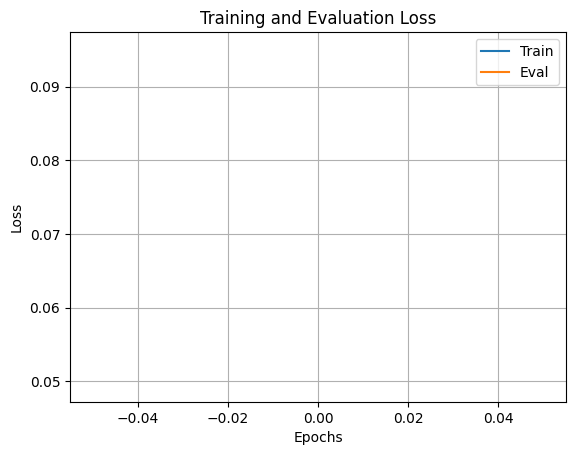

In [78]:
# 绘制训练损失曲线
plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Eval')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# 保存模型 保存的是文件 里面有config.json文件和model.safetensors模型文件
model.save_pretrained("./peoples_daily_ner_model")


In [81]:
# 推理模型
# example_sentence = "海钓比赛地点在厦门与金门"
example_sentence = "北京是中国的首都。"
inputs = tokenizer(example_sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [82]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 5.5332, -2.0215, -2.3632, -1.7335, -1.1529, -0.1443, -0.3947],
         [-2.0747, -1.8169, -2.6177,  0.3363, -2.5047,  5.4459, -0.6823],
         [-1.2705, -3.0797, -0.7016, -3.0688,  0.7253,  0.7293,  6.1000],
         [ 7.6070, -2.5106, -3.0227, -2.0992, -1.0515, -1.1190, -0.6119],
         [-1.2399, -2.2512, -2.5366, -0.3096, -2.3144,  5.7405, -0.6278],
         [ 0.0374, -2.7026, -1.2432, -3.1503,  0.2566, -0.7135,  6.1357],
         [ 7.0126, -2.2660, -3.1678, -2.0898, -0.9910, -0.8260, -0.5479],
         [ 6.3433, -2.6451, -3.1989, -1.9304, -1.3802, -0.9575, -0.1367],
         [ 5.9450, -2.6924, -2.9546, -2.3872, -0.9686, -1.1456,  0.6077],
         [ 7.0521, -2.3640, -3.1610, -1.4510, -1.6529, -0.7498, -0.9963],
         [ 1.9753, -1.7750, -1.9326, -0.9397, -0.8321,  0.4471,  0.1944]]]), hidden_states=None, attentions=None)

In [83]:
predictions

array([0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0])

In [84]:
# 推理模型
sentence = '日本外务省3月18日发布消息称，日本首相岸田文雄将于19至21日访问印度和柬埔寨。'
inputs = tokenizer(sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [85]:
predictions

array([0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 6, 0, 0])

In [91]:
len(predictions), len(list(sentence)), list(sentence)

(40,
 41,
 ['日',
  '本',
  '外',
  '务',
  '省',
  '3',
  '月',
  '1',
  '8',
  '日',
  '发',
  '布',
  '消',
  '息',
  '称',
  '，',
  '日',
  '本',
  '首',
  '相',
  '岸',
  '田',
  '文',
  '雄',
  '将',
  '于',
  '1',
  '9',
  '至',
  '2',
  '1',
  '日',
  '访',
  '问',
  '印',
  '度',
  '和',
  '柬',
  '埔',
  '寨',
  '。'])

In [92]:
for i in zip(list(sentence), predictions[1:-1]):
    print(i)

('日', 3)
('本', 4)
('外', 4)
('务', 4)
('省', 4)
('3', 0)
('月', 0)
('1', 0)
('8', 0)
('日', 0)
('发', 0)
('布', 0)
('消', 0)
('息', 0)
('称', 0)
('，', 5)
('日', 6)
('本', 0)
('首', 0)
('相', 1)
('岸', 2)
('田', 2)
('文', 2)
('雄', 0)
('将', 0)
('于', 0)
('1', 0)
('9', 0)
('至', 0)
('2', 0)
('1', 0)
('日', 5)
('访', 6)
('问', 0)
('印', 5)
('度', 6)
('和', 6)
('柬', 0)


In [98]:
# 推理模型
sentence1 = '岸田文雄将于19日访问印度和柬埔寨。..'
inputs = tokenizer(sentence1, return_tensors="pt").to(device)
with torch.no_grad():
    outputs1 = model(**inputs)
    predictions1 = torch.argmax(outputs1.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。

In [97]:
for i in zip(list(sentence1), predictions1[1:-1]):
    print(i)

('岸', 1)
('田', 2)
('文', 2)
('雄', 2)
('将', 0)
('于', 0)
('1', 0)
('日', 0)
('访', 0)
('问', 0)
('印', 5)
('度', 6)
('和', 0)
('柬', 5)
('埔', 6)
('寨', 6)
('。', 0)
('.', 0)
('.', 0)


In [99]:
for i in zip(list(sentence1), predictions1[1:-1]):
    print(i)

('岸', 1)
('田', 2)
('文', 2)
('雄', 2)
('将', 0)
('于', 0)
('1', 0)
('9', 0)
('日', 0)
('访', 0)
('问', 5)
('印', 6)
('度', 0)
('和', 5)
('柬', 6)
('埔', 6)
('寨', 0)
('。', 0)
('.', 0)


In [104]:
# print(tokenizer.decode(out['input_ids'][0]))
orgin_token = tokenizer.decode(inputs['input_ids'][0])
type(orgin_token), orgin_token

(str, '[CLS] 岸 田 文 雄 将 于 19 日 访 问 印 度 和 柬 埔 寨 。.. [SEP]')

In [105]:
for j in zip(orgin_token.split(' '), predictions1):
    print(j)

('[CLS]', 0)
('岸', 1)
('田', 2)
('文', 2)
('雄', 2)
('将', 0)
('于', 0)
('19', 0)
('日', 0)
('访', 0)
('问', 0)
('印', 5)
('度', 6)
('和', 0)
('柬', 5)
('埔', 6)
('寨', 6)
('。..', 0)
('[SEP]', 0)


In [ ]:
predictions

array([0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0])

### 模型推理

In [56]:
!pip install datasets

### gpt代码


In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from tqdm import tqdm

# 加载数据集
dataset = load_dataset("peoples_daily_ner")

# 初始化BERT tokenizer和模型
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertForTokenClassification.from_pretrained("bert-base-chinese", num_labels=len(dataset["train"].features["ner_tags"].feature))

# 将数据集转换为适用于BERT的格式
def tokenize_and_align_labels(example):
    tokens = tokenizer.tokenize(example["tokens"])
    labels = example["ner_tags"]
    return {"input_ids": tokenizer.convert_tokens_to_ids(tokens),
            "attention_mask": [1] * len(tokens),
            "labels": labels}

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# 准备数据加载器
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8)

# 移动模型到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义优化器和损失函数
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
train_losses = []
eval_losses = []
for epoch in range(3):
    # 训练
    model.train()
    epoch_train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Train"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits.view(-1, len(dataset["train"].features["ner_tags"].feature)), labels.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # 验证
    model.eval()
    epoch_eval_loss = 0
    for batch in tqdm(eval_dataloader, desc=f"Epoch {epoch+1} Eval"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits.view(-1, len(dataset["train"].features["ner_tags"].feature)), labels.view(-1))
            epoch_eval_loss += loss.item()
    eval_losses.append(epoch_eval_loss / len(eval_dataloader))

# 绘制训练损失曲线
plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Eval')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 保存模型
model.save_pretrained("./peoples_daily_ner_model")

# 推理模型
example_sentence = "北京是中国的首都。"
inputs = tokenizer(example_sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

# 部署模型
# 你可以使用保存的模型加载并在其他地方使用，例如在Flask或FastAPI中。
